In [10]:
import os
import glob
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
    LoadTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.acolite import ReadAcoliteProduct
from sdb_utils.ml_utils import (
    create_sdb_estimation,
    get_X_y_for_split,
    SplitType,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_bahamas'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 10, 19, 15, 55, 31),
  'D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSIL2A_20211019T155531_N9999_R011_T17RQJ_20220423T204757.SAFE')]

In [3]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders

['D:\\sdb_datasets\\sentinel_bahamas\\S2A_MSI_20211019T155531_ACOLITE_SUBSET']

In [5]:
bathy_eop_path = os.path.abspath(
    os.path.join(data_root_path, 'eopatches', 'bahamas_bathy_eop')
)
load_bathy_eop = LoadTask(bathy_eop_path)

output_label = 'bahamas_bathy_eop'

wf_nodes = linearly_connect_tasks(
    load_bathy_eop,
    OutputTask(output_label),
)
workflow = EOWorkflow(wf_nodes)

workflow_result = workflow.execute()
bahamas_bathy_eop = workflow_result.outputs[output_label]

input_bathy_task = InputTask(bahamas_bathy_eop)
input_bathy_node = EONode(input_bathy_task, inputs=tuple())

height, width, _ = bahamas_bathy_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape

l2a_archive_path = l2a_products[0][1]
read_l2a_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=bahamas_bathy_eop.bbox
)
read_l2a_node = EONode(read_l2a_eop_task, inputs=tuple())

acolite_product = 'L2W'
reflectance_type = 'rhow'
acolite_product_path = sentinel_acolite_folders[0]
acolite_data_feature = (FeatureType.DATA, f'{acolite_product}_data')
read_acolite_product_task = ReadAcoliteProduct(
    reference_bbox=bahamas_bathy_eop.bbox,
    feature=acolite_data_feature,
    acolite_product=acolite_product,
    reflectance_type=reflectance_type
)
read_acolite_node = EONode(read_acolite_product_task, inputs=tuple())

merge_patches_task = MergeEOPatchesTask()
merge_eop_node = EONode(
    merge_patches_task,
    inputs=[input_bathy_node, read_l2a_node, read_acolite_node]
)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.05],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)
train_test_split_node = EONode(train_test_split_task, inputs=[merge_eop_node])

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

read_merge_wf = EOWorkflow(
    [
        input_bathy_node,
        read_l2a_node,
        read_acolite_node,
        merge_eop_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node,
    ]
)

read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        read_l2a_node: {'sentinel_archive_path': l2a_archive_path},
        read_acolite_node: {'acolite_product_folder': acolite_product_path},
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 894, 1946, 12), dtype=uint16)
    L2W_data: numpy.ndarray(shape=(1, 894, 1946, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(894, 1946, 1), dtype=float64)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(894, 1946, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(894, 1946, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(894, 1946, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
    test_count: 1653194
    test_perc: 0.950262225502436
    train_count: 86530
    train_perc: 0.04973777449756398
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((758523.8845987623, 2793786.7214435483), (777983.8845987623, 2802726.7214435483)), crs=CRS('32617'))
  timestamp=[datetime.datetime(2021, 10, 19, 15, 55, 31), datetime.datetime(2021, 10, 19, 15, 56, 16)]
)

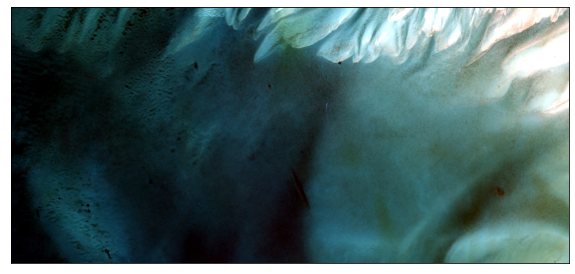

In [6]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)
plt.show()

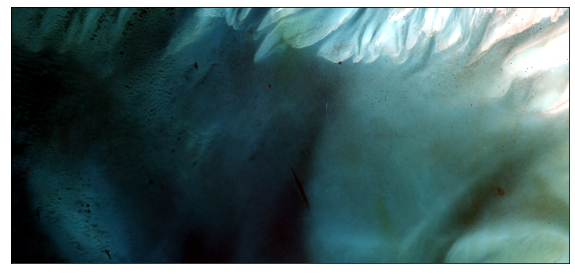

In [7]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2W_data"),
    stretch=True
)
plt.show()

In [11]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.7121148354131159

In [12]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

0.5585429184094813

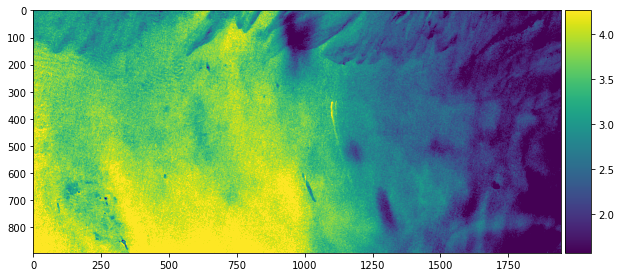

In [13]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

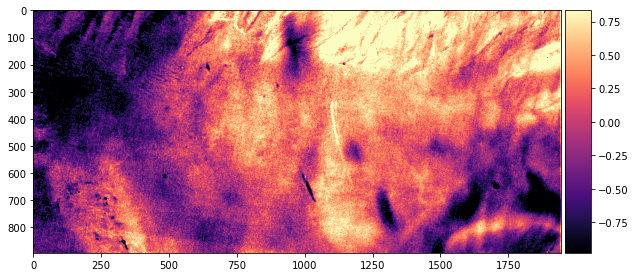

In [14]:
l2a_sdb_errors = l2a_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

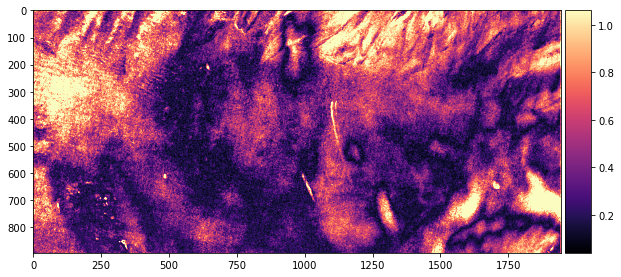

In [31]:
bathymetry_residuals_map = train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')] - estimated_bathymetry_stumpf_logratio
eolx.visualization.plot_ndarray_band(np.abs(bathymetry_residuals_map), cmap='magma')
plt.show()

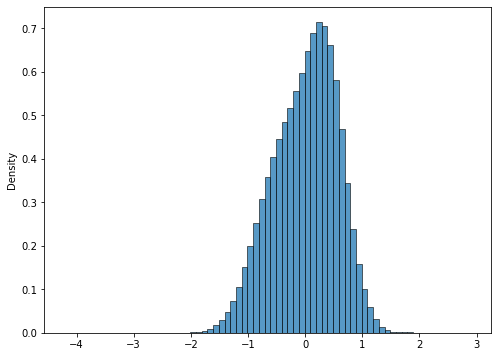

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

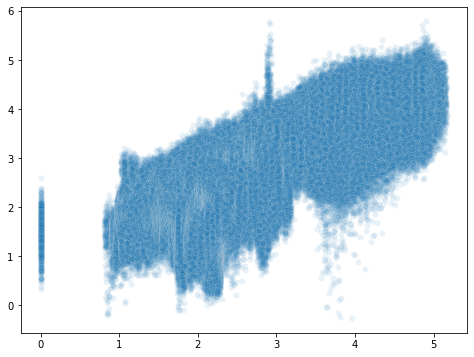

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [18]:
np.corrcoef(y_all, l2a_sdb_estimation_values)

array([[1.        , 0.84356699],
       [0.84356699, 1.        ]])

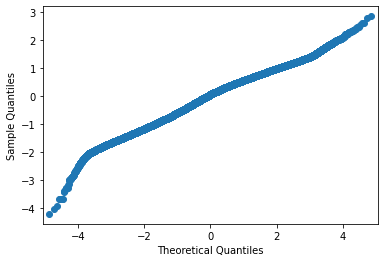

In [19]:
sm.qqplot(l2a_sdb_residuals)
plt.show()

## Acolite Example

In [20]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.7502229518144043

In [21]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

0.5202632765423115

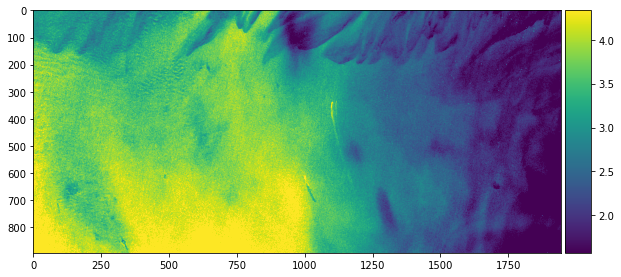

In [22]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

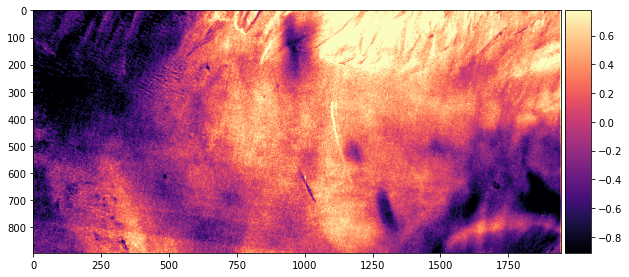

In [23]:
acolite_sdb_errors = acolite_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

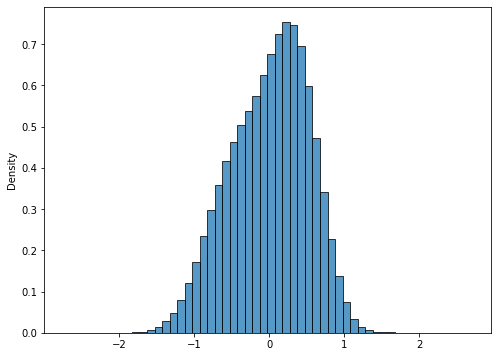

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.1, stat='density', ax=ax)
plt.show()

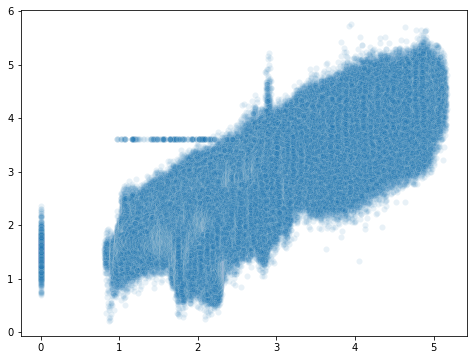

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=acolite_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [28]:
np.corrcoef(y_all, acolite_sdb_estimation_values)

array([[1.        , 0.86569051],
       [0.86569051, 1.        ]])

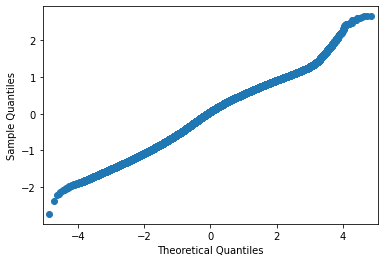

In [29]:
sm.qqplot(acolite_sdb_residuals)
plt.show()